# Building Autoencoders in PyTorch

1.   List item
2.   List item



In this tutorial, we will answer some common questions about autoencoders, and we will cover code examples of the following models:

- a simple autoencoder based on a fully-connected layer
- a deep fully-connected autoencoder
- a deep convolutional autoencoder
- a variational autoencoder

## What are autoencoders?
<img width = '80%' src ='https://blog.keras.io/img/ae/autoencoder_schema.jpg'>


"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. 
    
Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are `data-specific`, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are `lossy`, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are `learned automatically` from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an `encoding function`, a `decoding function`, and a `distance function` between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a `"loss" function`). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the `reconstruction loss`, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

## What are autoencoders good for?
Today two interesting practical applications of autoencoders are data denoising (which we will experiment later in this post), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, <a href='https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding'>t-SNE</a> is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. 

One reason why autoencoders have attracted so much research and attention is because they have long been thought to be a potential avenue for solving the problem of unsupervised learning, i.e. the learning of useful representations without the need for labels. Then again, autoencoders are not a true unsupervised learning technique (which would imply a different learning process altogether), they are a self-supervised technique, a specific instance of supervised learning where the targets are generated from the input data. In order to get self-supervised models to learn interesting features, you have to come up with an interesting synthetic target and loss function, and that's where problems arise: merely learning to reconstruct your input in minute detail might not be the right choice here. At this point there is significant evidence that focusing on the reconstruction of a picture at the pixel level, for instance, is not conductive to learning interesting, abstract features of the kind that label-supervized learning induces (where targets are fairly abstract concepts "invented" by humans such as "dog", "car"...). In fact, one may argue that the best features in this regard are those that are the worst at exact input reconstruction while achieving high performance on the main task that you are interested in (classification, localization, etc).

## MNIST Data Preprocess

In [ ]:
! pip install torchinfo

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchinfo import summary
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

### Load MINST Dataset

In [ ]:
# load from torch vision package
train_dataset = torchvision.datasets.MNIST('./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST('./data',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/Users/rliu/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# check shape and range of image

# total training samples. Each sample is a tuple
len(train_dataset)

# the first training sample - shape of x
train_dataset[0][0].size()
train_dataset[0][0].min()
train_dataset[0][0].max()

# the first training sample - y
train_dataset[0][1]

60000

torch.Size([1, 28, 28])

tensor(0.)

tensor(1.)

5

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=False)

### A simple autoencoder based on a fully-connected layer

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [ ]:
class AE_FC(nn.Module):

    def __init__(self,input_dim,hidden_dim):
        super(AE_FC, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)

        return decoder_output

In [ ]:
batch_size = 64
input_dim = 784
hidden_dim = 32

AE_model = AE_FC(input_dim=input_dim, hidden_dim = hidden_dim)
summary(AE_model, input_size = (batch_size,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
AE_FC                                    --                        --
├─Sequential: 1-1                        [64, 32]                  --
│    └─Flatten: 2-1                      [64, 784]                 --
│    └─Linear: 2-2                       [64, 32]                  25,120
│    └─ReLU: 2-3                         [64, 32]                  --
├─Sequential: 1-2                        [64, 784]                 --
│    └─Linear: 2-4                       [64, 784]                 25,872
│    └─Sigmoid: 2-5                      [64, 784]                 --
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
Total mult-adds (M): 3.26
Input size (MB): 0.20
Forward/backward pass size (MB): 0.42
Params size (MB): 0.20
Estimated Total Size (MB): 0.82

### Train the model

In [ ]:
def train(train_dataset, test_dataset, device, model, batch_size=64, num_epochs=20, learning_rate = 1e-3):

  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
  valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)
  # move the model to device
  model = model.to(device)  # move the model to gpu or cpu

  # history
  history = {'train_loss': [],
             'valid_loss': [],
             }

  # set up loss function and optimizer
  #criterion = nn.MSELoss() 
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # pass in the parameters to be updated and learning rate

  # traning loop
  print('Training Starts:')
  num_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      model.train()  # start to train the model, activate training behavior
      train_loss = 0
      train_acc = 0
      for i, (images, _) in enumerate(train_loader):
          # reshape mini-batch data to [N, 784] matrix    28*28 =784
          # load it to the active device
          images = images.to(device)  
          
          # forward
          outputs = model(images)  # forward
          cur_train_loss = criterion(outputs, images.view(-1,784))  # loss
          # backward
          cur_train_loss.backward()  # run back propagation
          optimizer.step()  # optimizer update all model parameters
          optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
          # loss
          train_loss += cur_train_loss
          
      # valid
      model.eval()  # start to evaluate the model
      with torch.no_grad():  # tell pytorch not to update parameters
          val_loss = 0
        
          for images, _ in valid_loader:
              # calculate validation loss
              images = images.to(device)
              outputs = model(images)
              cur_valid_loss = criterion(outputs, images.view(-1,784))
              val_loss += cur_valid_loss
      
      # print & record
      train_loss = train_loss / len(train_loader)
      val_loss = val_loss / len(valid_loader)
      print(f"Epoch:{epoch + 1} / {num_epochs}, train loss:{train_loss:.5f}, valid loss:{val_loss:.5f}")
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(val_loss)

  return history, model

In [ ]:
history, model = train(train_dataset = train_dataset, test_dataset=test_dataset, device=device, model=AE_model)

Training Starts:
Epoch:1 / 20, train loss:0.04777, valid loss:0.02899
Epoch:2 / 20, train loss:0.02362, valid loss:0.01929
Epoch:3 / 20, train loss:0.01813, valid loss:0.01659
Epoch:4 / 20, train loss:0.01644, valid loss:0.01559
Epoch:5 / 20, train loss:0.01582, valid loss:0.01520
Epoch:6 / 20, train loss:0.01551, valid loss:0.01504
Epoch:7 / 20, train loss:0.01535, valid loss:0.01479
Epoch:8 / 20, train loss:0.01523, valid loss:0.01473
Epoch:9 / 20, train loss:0.01516, valid loss:0.01469
Epoch:10 / 20, train loss:0.01511, valid loss:0.01464
Epoch:11 / 20, train loss:0.01507, valid loss:0.01460
Epoch:12 / 20, train loss:0.01502, valid loss:0.01456
Epoch:13 / 20, train loss:0.01497, valid loss:0.01449
Epoch:14 / 20, train loss:0.01494, valid loss:0.01453
Epoch:15 / 20, train loss:0.01493, valid loss:0.01455
Epoch:16 / 20, train loss:0.01490, valid loss:0.01447
Epoch:17 / 20, train loss:0.01487, valid loss:0.01452
Epoch:18 / 20, train loss:0.01485, valid loss:0.01445
Epoch:19 / 20, train

We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [ ]:
import matplotlib.pyplot as plt

<Figure size 1440x288 with 0 Axes>

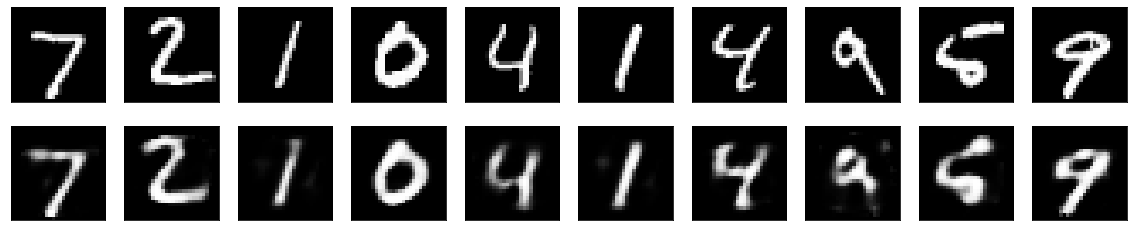

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_dataset[i][0].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    with torch.no_grad():
      pred = model(test_dataset[i][0]).reshape(28, 28)
    plt.imshow(pred)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Here's what we get. The top row is the original digits, and the bottom row is the reconstructed digits. We are losing quite a bit of detail with this basic approach.

### Deep autoencoder

We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as: 

In [ ]:
class AE_Deep(nn.Module):

    def __init__(self,input_dim,hidden_dim_1,hidden_dim_2,hidden_dim_3):
        super(AE_Deep, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_3),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim_3, hidden_dim_2),
            nn.ReLU(),
            nn.Linear(hidden_dim_2, hidden_dim_1),
            nn.ReLU(),
            nn.Linear(hidden_dim_1, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(encoder_output)

        return decoder_output

In [ ]:
AE_Deep_model = AE_Deep(784,128,64,32)
summary(AE_Deep_model, input_size = (batch_size,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
AE_Deep                                  --                        --
├─Sequential: 1-1                        [64, 32]                  --
│    └─Flatten: 2-1                      [64, 784]                 --
│    └─Linear: 2-2                       [64, 128]                 100,480
│    └─ReLU: 2-3                         [64, 128]                 --
│    └─Linear: 2-4                       [64, 64]                  8,256
│    └─ReLU: 2-5                         [64, 64]                  --
│    └─Linear: 2-6                       [64, 32]                  2,080
│    └─ReLU: 2-7                         [64, 32]                  --
├─Sequential: 1-2                        [64, 784]                 --
│    └─Linear: 2-8                       [64, 64]                  2,112
│    └─ReLU: 2-9                         [64, 64]                  --
│    └─Linear: 2-10                      [64, 128]                 8,32

In [ ]:
history, model_ae_deep = train(train_dataset = train_dataset, test_dataset=test_dataset, device=device, model=AE_Deep_model)

Training Starts:
Epoch:1 / 20, train loss:0.04990, valid loss:0.03100
Epoch:2 / 20, train loss:0.02645, valid loss:0.02285
Epoch:3 / 20, train loss:0.02162, valid loss:0.01995
Epoch:4 / 20, train loss:0.01898, valid loss:0.01782
Epoch:5 / 20, train loss:0.01736, valid loss:0.01629
Epoch:6 / 20, train loss:0.01624, valid loss:0.01528
Epoch:7 / 20, train loss:0.01524, valid loss:0.01437
Epoch:8 / 20, train loss:0.01429, valid loss:0.01371
Epoch:9 / 20, train loss:0.01353, valid loss:0.01288
Epoch:10 / 20, train loss:0.01293, valid loss:0.01240
Epoch:11 / 20, train loss:0.01248, valid loss:0.01207
Epoch:12 / 20, train loss:0.01206, valid loss:0.01168
Epoch:13 / 20, train loss:0.01167, valid loss:0.01127
Epoch:14 / 20, train loss:0.01134, valid loss:0.01100
Epoch:15 / 20, train loss:0.01106, valid loss:0.01070
Epoch:16 / 20, train loss:0.01079, valid loss:0.01065
Epoch:17 / 20, train loss:0.01057, valid loss:0.01026
Epoch:18 / 20, train loss:0.01034, valid loss:0.01021
Epoch:19 / 20, train

Our reconstructed digits look a bit better.

<Figure size 1440x288 with 0 Axes>

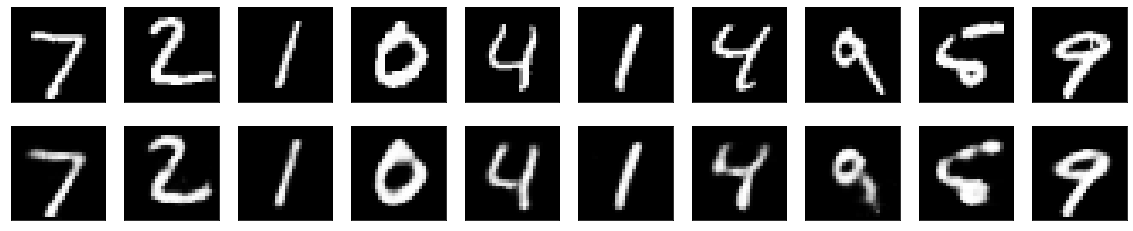

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_dataset[i][0].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    with torch.no_grad():
      pred = model_ae_deep(test_dataset[i][0]).reshape(28, 28)
    plt.imshow(pred)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional autoencoder


Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders -- they simply perform much better.

In [ ]:
class AE_Conv(nn.Module):

    def __init__(self):
        super(AE_Conv, self).__init__()

        self.encoder_cnn = nn.Sequential(
             # input (num_batch, 1, 28, 28)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding='same'),  # (num_batch, 16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #(num_batch, 16, 14, 14)  if stride is not provided, it will default to kernel_size
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding='same'),  # (num_batch, 8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # (num_batch, 8, 7, 7)
            nn.Flatten()
        )

        self.encoder_lin = nn.Sequential(
            nn.Linear(in_features=392, out_features=64),  # 392 = 8 * 7 * 7  input_shape (num_batch, 392)
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32)
        )

        self.decoder_lin = nn.Sequential(
            nn.Linear(in_features=32, out_features=64),  
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=392)
        )
        
        self.decoder_cnn = nn.Sequential(
            nn.Unflatten(dim=1, unflattened_size=(8, 7, 7)),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same'),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding='same'),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        encoder_cnn_output = self.encoder_cnn(x)
        encoder_lin_output = self.encoder_lin(encoder_cnn_output)
        decoder_lin_output = self.decoder_lin(encoder_lin_output)
        decoder_cnn_output = self.decoder_cnn(decoder_lin_output)

        return decoder_cnn_output.view(-1,784)

In [ ]:
AE_Conv_model = AE_Conv()
summary(AE_Conv_model, (10, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AE_Conv                                  --                        --
├─Sequential: 1-1                        [10, 392]                 --
│    └─Conv2d: 2-1                       [10, 16, 28, 28]          160
│    └─ReLU: 2-2                         [10, 16, 28, 28]          --
│    └─MaxPool2d: 2-3                    [10, 16, 14, 14]          --
│    └─Conv2d: 2-4                       [10, 8, 14, 14]           1,160
│    └─ReLU: 2-5                         [10, 8, 14, 14]           --
│    └─MaxPool2d: 2-6                    [10, 8, 7, 7]             --
│    └─Flatten: 2-7                      [10, 392]                 --
├─Sequential: 1-2                        [10, 32]                  --
│    └─Linear: 2-8                       [10, 64]                  25,152
│    └─ReLU: 2-9                         [10, 64]                  --
│    └─Linear: 2-10                      [10, 32]                  2,080
├─Se

In [ ]:
history, model_ae_cov = train(train_dataset = train_dataset, test_dataset=test_dataset, device=device, model=AE_Conv_model)

Training Starts:
Epoch:1 / 20, train loss:0.04249, valid loss:0.02055
Epoch:2 / 20, train loss:0.01744, valid loss:0.01473
Epoch:3 / 20, train loss:0.01364, valid loss:0.01217
Epoch:4 / 20, train loss:0.01163, valid loss:0.01054
Epoch:5 / 20, train loss:0.01041, valid loss:0.00972
Epoch:6 / 20, train loss:0.00961, valid loss:0.00916
Epoch:7 / 20, train loss:0.00902, valid loss:0.00859
Epoch:8 / 20, train loss:0.00850, valid loss:0.00824
Epoch:9 / 20, train loss:0.00809, valid loss:0.00767
Epoch:10 / 20, train loss:0.00774, valid loss:0.00742
Epoch:11 / 20, train loss:0.00742, valid loss:0.00720
Epoch:12 / 20, train loss:0.00711, valid loss:0.00683
Epoch:13 / 20, train loss:0.00688, valid loss:0.00671
Epoch:14 / 20, train loss:0.00668, valid loss:0.00658
Epoch:15 / 20, train loss:0.00651, valid loss:0.00622
Epoch:16 / 20, train loss:0.00635, valid loss:0.00619
Epoch:17 / 20, train loss:0.00623, valid loss:0.00601
Epoch:18 / 20, train loss:0.00611, valid loss:0.00584
Epoch:19 / 20, train

<Figure size 1440x288 with 0 Axes>

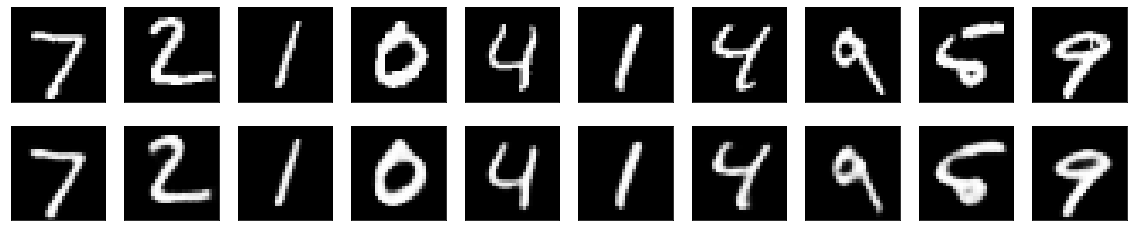

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_dataset[i][0].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    with torch.no_grad():
      pred = model_ae_cov(test_dataset[i][0].unsqueeze(dim = 0)).reshape(28, 28)
    plt.imshow(pred)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Denoising Autoencoder

Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [ ]:
def add_noise(inputs,noise_factor=0.5):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

Here's what the noisy digits look like:

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

<Figure size 1440x288 with 0 Axes>

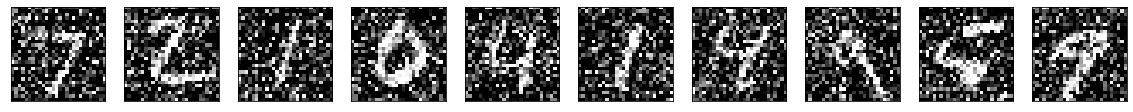

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display noisy digits
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(add_noise(test_dataset[i][0]).squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We'll use the previous convolutional autoencoder:

In [ ]:
def train_add_noise(train_dataset, test_dataset, device, model, batch_size=64, num_epochs=20, learning_rate = 1e-3,noise_factor=0.5):

  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
  valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)
  # move the model to device
  model = model.to(device)  # move the model to gpu or cpu

  # history
  history = {'train_loss': [],
             'valid_loss': [],
             }

  # set up loss function and optimizer
  criterion = nn.MSELoss() 
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # pass in the parameters to be updated and learning rate

  # traning loop
  print('Training Starts:')
  num_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      model.train()  # start to train the model, activate training behavior
      train_loss = 0
      train_acc = 0
      for i, (images, _) in enumerate(train_loader):
          # reshape mini-batch data to [N, 784] matrix    28*28 =784
          # load it to the active device
          
          # inject noise
          image_noisy = add_noise(images,noise_factor)
          image_noisy = image_noisy.to(device) 
          
          # forward
          outputs = model(image_noisy)  # forward
          
          # loss is calculated by the difference between original and resconstructed images
          images = images.to(device)
          cur_train_loss = criterion(outputs, images.view(-1,784))  # loss
          
          # backward
          cur_train_loss.backward()  # run back propagation
          optimizer.step()  # optimizer update all model parameters
          optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
          # loss
          train_loss += cur_train_loss
          
      # valid
      model.eval()  # start to evaluate the model
      with torch.no_grad():  # tell pytorch not to update parameters
          val_loss = 0
        
          for images, _ in valid_loader:
              # calculate validation loss
              image_noisy = add_noise(images,noise_factor)
              image_noisy = image_noisy.to(device) 
              #images = images.to(device)
              outputs = model(image_noisy)
              
              images = images.to(device) 
              cur_valid_loss = criterion(outputs, images.view(-1,784))
              val_loss += cur_valid_loss
      
      # print & record
      train_loss = train_loss / len(train_loader)
      val_loss = val_loss / len(valid_loader)
      print(f"Epoch:{epoch + 1} / {num_epochs}, train loss:{train_loss:.5f}, valid loss:{val_loss:.5f}")
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(val_loss)

  return history, model

In [ ]:
history, model_ae_deno = train_add_noise(train_dataset = train_dataset, test_dataset=test_dataset, device=device, model=AE_Conv_model)

Training Starts:
Epoch:1 / 20, train loss:0.01763, valid loss:0.01523
Epoch:2 / 20, train loss:0.01503, valid loss:0.01448
Epoch:3 / 20, train loss:0.01451, valid loss:0.01408
Epoch:4 / 20, train loss:0.01419, valid loss:0.01391
Epoch:5 / 20, train loss:0.01398, valid loss:0.01382
Epoch:6 / 20, train loss:0.01385, valid loss:0.01348
Epoch:7 / 20, train loss:0.01372, valid loss:0.01353
Epoch:8 / 20, train loss:0.01360, valid loss:0.01350
Epoch:9 / 20, train loss:0.01353, valid loss:0.01325
Epoch:10 / 20, train loss:0.01343, valid loss:0.01346
Epoch:11 / 20, train loss:0.01333, valid loss:0.01306
Epoch:12 / 20, train loss:0.01324, valid loss:0.01296
Epoch:13 / 20, train loss:0.01319, valid loss:0.01294
Epoch:14 / 20, train loss:0.01307, valid loss:0.01305
Epoch:15 / 20, train loss:0.01298, valid loss:0.01277
Epoch:16 / 20, train loss:0.01291, valid loss:0.01264
Epoch:17 / 20, train loss:0.01285, valid loss:0.01263
Epoch:18 / 20, train loss:0.01284, valid loss:0.01287
Epoch:19 / 20, train

Now let's take a look at the results. Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.

It seems to work pretty well.

<Figure size 1440x288 with 0 Axes>

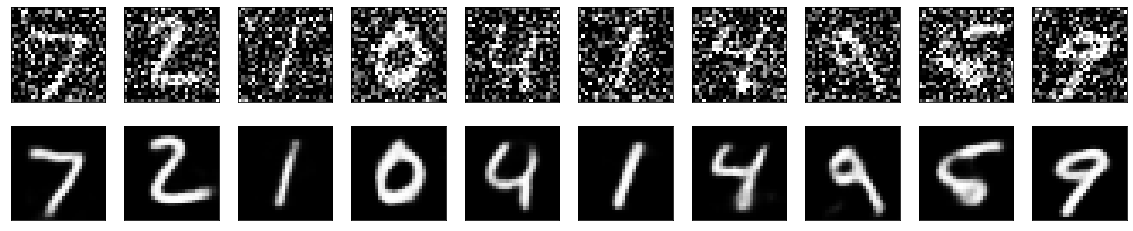

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display noisy digits
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(add_noise(test_dataset[i][0]).squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    with torch.no_grad():
      pred = model_ae_deno(add_noise(test_dataset[i][0]).unsqueeze(dim = 0).to(device)).reshape(28, 28)
    pred = pred.to('cpu').detach().numpy()
    plt.imshow(pred)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Variational autoencoder (VAE)

Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples `x` into two parameters in a latent space, which we will note `z_mean` and `z_log_var`. Then, we randomly sample similar points `z` from the latent normal distribution that is assumed to generate the data, via `z = z_mean + exp(z_log_var) * epsilon`, where `epsilon` is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a `reconstruction loss` forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the `KL divergence` between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.


<img width = '80%' src ='https://user-images.githubusercontent.com/16206648/51078000-ed211680-16ae-11e9-8d03-590cda640b0e.png'>


First, here's our encoder network, mapping inputs to our latent distribution parameters. Note that `z_sigma = exp(0.5 * z_log_var)`. We use a dense layer to generate the `log` of the variance (`z_sigma`) of the latent variable `z`.

We can use these parameters to sample new similar points from the latent space, i.e. $z=z\_mu+z\_sigma * eps$, where eps follows Gaussian distribution $N(0, 1)$.

Now, we need to define a custom loss: the `KL divergence regularization` term. This loss can be defined through a custom layer. Check the formula in your notes!

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self,latent_dim):
        super(VariationalEncoder, self).__init__()
        self.flatten = nn.Flatten()
        
        # shared linear layer
        self.linear1 = nn.Linear(784, 512)
        
        self.relu = nn.ReLU()
        
        # dense layer to produce mean mean
        self.linear2 = nn.Linear(512, latent_dim)
        
        # deanse layer to produce variance
        self.linear3 = nn.Linear(512, latent_dim)
        
        # reparametrizing
        self.N = torch.distributions.Normal(0, 1)
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        mu =  self.linear2(x)
        logvar = self.linear3(x)   # output log(var)
        
        sigma = torch.exp(0.5*logvar) # standard deviation
        
        z = mu + sigma*self.N.sample(mu.shape)
        
        # kl divergence of the batch
        kl = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
        
        return z, kl


In [ ]:
class VAE(nn.Module):

    def __init__(self,latent_dim):
        super(VAE, self).__init__()

        self.encoder = VariationalEncoder(latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        encoder_output, kl = self.encoder(x)
        decoder_output = self.decoder(encoder_output)

        return decoder_output, kl

In [ ]:
# latent dim is set to 2. We'll visualize latent variables

VAE_model = VAE(latent_dim = 2)
summary(VAE_model, (10, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      --                        --
├─VariationalEncoder: 1-1                [10, 2]                   --
│    └─Flatten: 2-1                      [10, 784]                 --
│    └─Linear: 2-2                       [10, 512]                 401,920
│    └─ReLU: 2-3                         [10, 512]                 --
│    └─Linear: 2-4                       [10, 2]                   1,026
│    └─Linear: 2-5                       [10, 2]                   1,026
├─Sequential: 1-2                        [10, 784]                 --
│    └─Linear: 2-6                       [10, 512]                 1,536
│    └─ReLU: 2-7                         [10, 512]                 --
│    └─Linear: 2-8                       [10, 784]                 402,192
│    └─Sigmoid: 2-9                      [10, 784]                 --
Total params: 807,700
Trainable params: 807,700
Non-trainable para

In [ ]:
def train_vae(train_dataset, test_dataset, device, model, batch_size=64, num_epochs=20, learning_rate = 1e-3):

  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
  valid_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)
  # move the model to device
  model = model.to(device)  # move the model to gpu or cpu

  # history
  history = {'train_loss': [],
             'valid_loss': [],
             }

  # set up loss function and optimizer
  criterion = nn.MSELoss(reduction='sum') # the default reduction is mean, here we sum errors of all pixels to matach with KL loss
    
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # pass in the parameters to be updated and learning rate

  # traning loop
  print('Training Starts:')
  num_total_steps = len(train_loader)
  for epoch in range(num_epochs):
      model.train()  # start to train the model, activate training behavior
      train_loss = 0
      train_acc = 0
      for i, (images, _) in enumerate(train_loader):
          # reshape mini-batch data to [N, 784] matrix    28*28 =784
          # load it to the active device
          images = images.to(device)  
          
          # forward
          outputs, kl = model(images)  # forward
          cur_train_loss = criterion(outputs, images.view(-1,784))  # loss
          loss = cur_train_loss + kl
        
          # backward
          loss.backward()  # run back propagation
          optimizer.step()  # optimizer update all model parameters
          optimizer.zero_grad()  # set gradient to zero, avoid gradient accumulating
          # loss
          train_loss += loss
          
      # valid
      model.eval()  # start to train the model, activate training behavior
      with torch.no_grad():  # tell pytorch not to update parameters
          val_loss = 0
        
          for images, _ in valid_loader:
              # calculate validation loss
              images = images.to(device)
              outputs, kl = model(images)
              cur_valid_loss = criterion(outputs, images.view(-1,784))
              val_loss += cur_valid_loss + kl
      
      # print & record
      train_loss = train_loss / len(train_loader.dataset)
      val_loss = val_loss / len(valid_loader.dataset)
      print(f"Epoch:{epoch + 1} / {num_epochs}, train loss:{train_loss:.5f}, valid loss:{val_loss:.5f}")
      history['train_loss'].append(train_loss)
      history['valid_loss'].append(val_loss)

  return history, model

In [ ]:
history, model_vae = train_vae(train_dataset = train_dataset, test_dataset=test_dataset, 
                               device=device, model=VAE_model, num_epochs = 50)

Training Starts:
Epoch:1 / 50, train loss:46.18602, valid loss:42.69619
Epoch:2 / 50, train loss:41.98466, valid loss:41.47429
Epoch:3 / 50, train loss:40.99945, valid loss:40.70687
Epoch:4 / 50, train loss:40.34120, valid loss:40.28370
Epoch:5 / 50, train loss:39.86843, valid loss:39.84401
Epoch:6 / 50, train loss:39.54775, valid loss:39.70466
Epoch:7 / 50, train loss:39.24933, valid loss:39.34459
Epoch:8 / 50, train loss:39.01389, valid loss:39.14194
Epoch:9 / 50, train loss:38.82203, valid loss:39.01405
Epoch:10 / 50, train loss:38.67213, valid loss:38.90374
Epoch:11 / 50, train loss:38.48819, valid loss:38.71006
Epoch:12 / 50, train loss:38.34547, valid loss:38.66927
Epoch:13 / 50, train loss:38.23227, valid loss:38.45131
Epoch:14 / 50, train loss:38.10263, valid loss:38.37040
Epoch:15 / 50, train loss:38.00465, valid loss:38.36700
Epoch:16 / 50, train loss:37.89780, valid loss:38.28165
Epoch:17 / 50, train loss:37.81187, valid loss:38.09804
Epoch:18 / 50, train loss:37.73848, vali

In [ ]:
model_vae = model_vae.to(device)

Similarly, we can compared generated images with the original ones

<Figure size 1440x288 with 0 Axes>

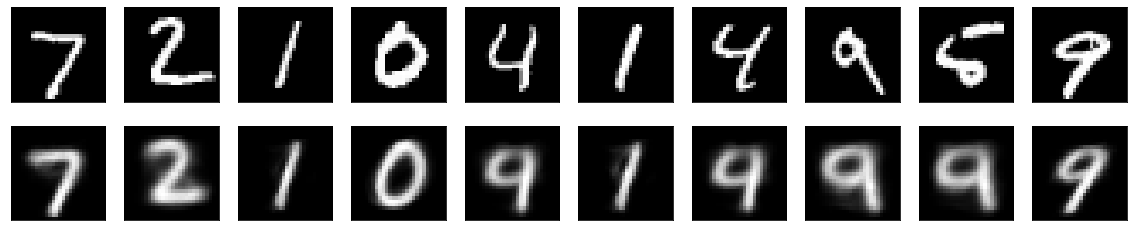

In [ ]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_dataset[i][0].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    with torch.no_grad():
      pred, _ = model_vae(test_dataset[i][0].unsqueeze(dim = 0).to(device))
    
    pred = pred.reshape(28, 28)
    pred = pred.to('cpu').detach().numpy()
    plt.imshow(pred)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also cluster the latent variable `z` generated from test images. We first get the mean value of `z` in the encoder for each of the testing images and then cluster these mean values.

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    plt.figure(figsize=(8,6))
    
    for i, (x, y) in enumerate(data):
        z, _ = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()      
       
        plt.scatter(z[:, 0], z[:, 1], c=y, alpha=.4, s=3**2, cmap='viridis')
        if i > num_batches:
            plt.colorbar()
            plt.xlim((-4, 4))
            plt.ylim((-4, 4))
            break

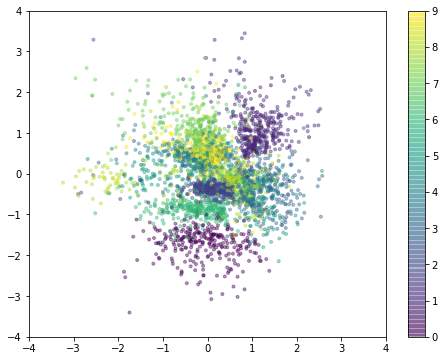

In [ ]:
plot_latent(model_vae, valid_loader)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [ ]:
def plot_reconstructed(autoencoder, r0=(0.01, 0.99), r1=(0.99, 0.01), n=15):
    w = 28
    img = np.zeros((n*w, n*w))
    
    # sample n points from normal distribution between quantile [1% - 99%]
    z1 = norm.ppf(np.linspace(quantile_min, quantile_max, n))
    z2 = norm.ppf(np.linspace(quantile_max, quantile_min, n))
    
    # create latent variable Z as mesh between z1 and z2 
    z_grid = np.dstack(np.meshgrid(z1, z2))
    z_grid = torch.Tensor(z_grid).to(device)
    
    # reconstruct images using Z
    x_pred_grid = model_vae.decoder(z_grid.reshape(n*n, 2)) \
                     .reshape(n, n, img_rows, img_cols)
    x_pred_grid = x_pred_grid.to('cpu').detach().numpy()

    # plot Z
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')

    ax.set_xticks(np.arange(0, n*w, w) + .5 * img_rows)
    ax.set_xticklabels(map('{:.2f}'.format, z1), rotation=90)

    ax.set_yticks(np.arange(0, n*w, img_cols) + .5 * w)
    ax.set_yticklabels(map('{:.2f}'.format, z2))

    ax.set_xlabel('$z_1$')
    ax.set_ylabel('$z_2$')

    plt.show()

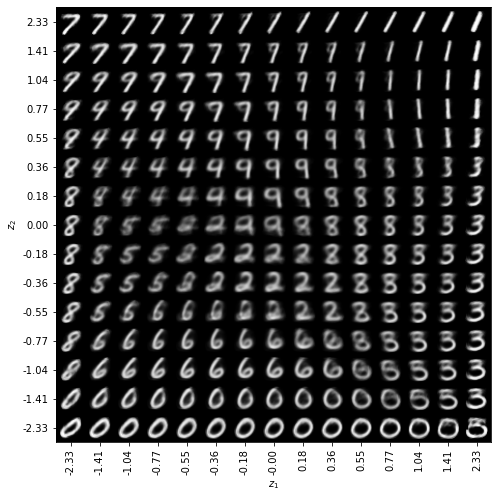

In [ ]:
plot_reconstructed(model_vae)